In [ ]:
import pandas as _hex_pandas
import datetime as _hex_datetime
import json as _hex_json

In [ ]:
hex_scheduled = _hex_json.loads("false")

In [ ]:
hex_user_email = _hex_json.loads("\"example-user@example.com\"")

In [ ]:
hex_run_context = _hex_json.loads("\"logic\"")

In [ ]:
hex_timezone = _hex_json.loads("\"UTC\"")

### Problem Solution
- A data analytical tool that perform analystics on appointment data from USHAURI app
- A predictive model that compare appointment keeping patterns for those who recieve sms reminders. The model then predict the patients that are mor likely to keep their appointment.


#### Function of the analytical tool

- [ ] perform descriptive statistics to obtain **dataset count** and characterize patients and visualize the data using graphs.
- [ ] Perform comparative analysis by tabbing the variables to compare to our dependent and independent variable.
- [ ] Perform time series analysis to examine the appointment keeping patterns. 
- [ ] predictive analysis.  The tool to clients data and compare appointment keeping patterns for those who recieve sms.

In [ ]:
! pip install prophet

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt # visualization library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc,classification_report,confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score,f1_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import itertools
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LogisticRegression
from prophet import Prophet

import time

# load data
data = pd.read_csv("appointment.csv")

df = pd.DataFrame(data)
#data.head(5)

#print(df.dtypes)

import warnings        
# ignore filters
warnings.filterwarnings("ignore") # if there is a warning after some code

# grouping patients by genders, marital status, and perform count etc.
gender_count = df['gender'].value_counts()
app_status_count = df['app_status'].value_counts()
marital_count = df['marital'].value_counts()
outcome_count = df['outcome'].value_counts()
final_outcome_count = df['final_outcome'].value_counts()

print('\n\nGender count\n',gender_count, '\n\n App status\n', app_status_count, '\n\n Marital count\n', marital_count
      , '\n\n outcome Count\n', outcome_count, '\n\n Final outcome\n', final_outcome_count)

# convert strings and objects to numeric

def convert_to_numeric(x):
  if x=='Trans-gender': return 4
  if x=='Unavailable': return 3
  if x=='Female': return 2
  if x=='Male':   return 1

df['gender'] = df['gender'].apply(convert_to_numeric)

marital_map = {'Maried polygamous': 1,'Single':2,'Widowed':3,
               'Divorced':4,'Cohabiting':5, 'Unavailable':6,
               'Not Applicable':0, 'Maried polygamous':7}

outcome_map = {'Client Contacted':1, 'Client not Contacted':2, 
               'Informant Contacted':3}

final_outcome_map = {'Client returned to care':1,'Self Transfer':2, 
                     'Client Declined Care':3, 'Rescheduling':4,
                     'Client Found':5, 'Client not Found':6,
                     'Client Too Sick To Attend Appo':7,
                     'Challenging Client':8, 'Other':9, 'Dead':10
                     }

app_status_map = {'Defaulted':1, 'Missed':2,'LTFU':3, 'Notified':4,'Booked':5 }

df['marital'] = df.marital.map(marital_map)
df['outcome'] = df.outcome.map(outcome_map)
df['final_outcome'] = df.final_outcome.map(final_outcome_map)
df['app_status'] = df.app_status.map(app_status_map)

df.fillna(0)
#print(df.head(5))
df.rename(columns={'Sigoti Health Centre':'hospital'}, inplace=True)


In [ ]:
df['appntmnt_date'] = df['appntmnt_date'].astype(str)

#count - plot
sns.countplot(x='marital', 
              data=data)

plt.show()

g = sns.catplot(x="gender", hue="app_status", col="outcome",

                data=data, kind="count",

                height=4, aspect=.7);

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688926 entries, 0 to 688925
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   hospital        688926 non-null  object 
 1   mfl_code        688926 non-null  int64  
 2   partner         688926 non-null  object 
 3   county          688926 non-null  object 
 4   sub_county      688926 non-null  object 
 5   clinic_number   688926 non-null  object 
 6   gender          688926 non-null  int64  
 7   marital         301659 non-null  float64
 8   appntmnt_date   688926 non-null  object 
 9   outcome         688926 non-null  int64  
 10  final_outcome   688926 non-null  int64  
 11  app_status      688926 non-null  int64  
 12  days_defaulted  688911 non-null  float64
 13  Appntmnt_yr     688926 non-null  object 
dtypes: float64(2), int64(5), object(7)
memory usage: 73.6+ MB


In [ ]:

print('\n\nGender count\n',gender_count, '\n\n App status\n', app_status_count, '\n\n Marital count\n', marital_count
      , '\n\n outcome Count\n', outcome_count, '\n\n Final outcome\n', final_outcome_count)



Gender count
 Female          466036
Male            221695
Unavailable        670
Trans-gender       525
Name: gender, dtype: int64 

 App status
 Defaulted    263383
Missed       254044
LTFU         138774
Notified      20960
Booked        11765
Name: app_status, dtype: int64 

 Marital count
 Married Monogamous    387267
Single                127536
Widowed                52806
Divorced               49614
Cohabiting             33258
Unavailable            20470
Not Applicable         12846
Maried polygamous       5129
Name: marital, dtype: int64 

 outcome Count
 Client Contacted        576343
Client not Contacted     89614
Informant Contacted      22969
Name: outcome, dtype: int64 

 Final outcome
 Client returned to care           551076
Other                             127223
Self Transfer                       5186
Client Declined Care                2581
Dead                                1365
Client not Found                     626
Rescheduling                         4

**Patient count and characterization.**





In [ ]:
#check for missing values
#df.isnull().sum()

create data chunks based on mfl_code. This will act as base for predicting and performing analysis for each individual.  The code applied per mfl_code can be substituted with client id and same prediction method applied for patient clinical appointment patterns.

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mfl_code,688926.0,13820.575864,1780.280136,10000.0,13468.0,13738.0,14020.0,23285.0
gender,688926.0,1.680699,0.473144,1.0,1.0,2.0,2.0,4.0
marital,301659.0,3.106020,1.510975,0.0,2.0,3.0,4.0,7.0
outcome,688926.0,1.196758,0.474052,1.0,1.0,1.0,1.0,3.0
final_outcome,688926.0,2.519324,3.119865,1.0,1.0,1.0,1.0,10.0
app_status,688926.0,1.931206,0.924341,1.0,1.0,2.0,2.0,5.0
days_defaulted,688911.0,36.665264,107.980035,-84.0,2.0,7.0,26.0,34624.0


In [ ]:
#descriptive analysis
# Most commonly affected sub_county
for i in df['sub_county'].unique():
    print("Sub_County: {}\t \t App Status and Count: {}\n".format(i,df[df['sub_county']
                                                              ==i]['app_status']
                                                       .value_counts().head(1)))

Sub_County: Kisumu East	 	 App Status and Count: 1    4135
Name: app_status, dtype: int64

Sub_County: Nyakach	 	 App Status and Count: 2    15873
Name: app_status, dtype: int64

Sub_County: Nyando	 	 App Status and Count: 1    24648
Name: app_status, dtype: int64

Sub_County: Muhoroni	 	 App Status and Count: 1    25347
Name: app_status, dtype: int64

Sub_County: Kisumu Central	 	 App Status and Count: 1    38123
Name: app_status, dtype: int64

Sub_County: Kisumu West	 	 App Status and Count: 1    8149
Name: app_status, dtype: int64

Sub_County: Kabondo Kasipul	 	 App Status and Count: 2    5734
Name: app_status, dtype: int64

Sub_County: Karachuonyo	 	 App Status and Count: 1    7924
Name: app_status, dtype: int64

Sub_County: Masinga	 	 App Status and Count: 3    504
Name: app_status, dtype: int64

Sub_County: Mvita	 	 App Status and Count: 2    244
Name: app_status, dtype: int64

Sub_County: Homa Bay Town	 	 App Status and Count: 2    14741
Name: app_status, dtype: int64

Sub_Count

In [ ]:
#specific hospital compared to specific outcome
for i in df['mfl_code'].unique():
    print("mfl_code: {}\t\tOutcome and Count: {}\n".format(i,df[df['mfl_code']
                                                              ==i]['outcome']
                                                       .value_counts().head(1)))

mfl_code: 13890		Outcome and Count: 1    6052
Name: outcome, dtype: int64

mfl_code: 14086		Outcome and Count: 1    1331
Name: outcome, dtype: int64

mfl_code: 16283		Outcome and Count: 1    1110
Name: outcome, dtype: int64

mfl_code: 17110		Outcome and Count: 1    614
Name: outcome, dtype: int64

mfl_code: 14027		Outcome and Count: 1    5679
Name: outcome, dtype: int64

mfl_code: 13831		Outcome and Count: 1    5868
Name: outcome, dtype: int64

mfl_code: 13785		Outcome and Count: 1    6981
Name: outcome, dtype: int64

mfl_code: 13738		Outcome and Count: 1    34824
Name: outcome, dtype: int64

mfl_code: 13687		Outcome and Count: 1    1610
Name: outcome, dtype: int64

mfl_code: 14024		Outcome and Count: 1    786
Name: outcome, dtype: int64

mfl_code: 14096		Outcome and Count: 1    3603
Name: outcome, dtype: int64

mfl_code: 13521		Outcome and Count: 1    2970
Name: outcome, dtype: int64

mfl_code: 13591		Outcome and Count: 1    899
Name: outcome, dtype: int64

mfl_code: 13880		Outcome an

In [ ]:
#specific hospital compared to specific outcome
for i in df['mfl_code'].unique():
    print("mfl_code: {}\t\tFinal Outcome and Count: {}\n".format(i,df[df['mfl_code']
                                                              ==i]['final_outcome']
                                                       .value_counts().head(1)))

mfl_code: 13890		Final Outcome and Count: 9    3341
Name: final_outcome, dtype: int64

mfl_code: 14086		Final Outcome and Count: 1    1290
Name: final_outcome, dtype: int64

mfl_code: 16283		Final Outcome and Count: 1    908
Name: final_outcome, dtype: int64

mfl_code: 17110		Final Outcome and Count: 1    638
Name: final_outcome, dtype: int64

mfl_code: 14027		Final Outcome and Count: 1    4251
Name: final_outcome, dtype: int64

mfl_code: 13831		Final Outcome and Count: 1    3474
Name: final_outcome, dtype: int64

mfl_code: 13785		Final Outcome and Count: 9    6703
Name: final_outcome, dtype: int64

mfl_code: 13738		Final Outcome and Count: 9    22306
Name: final_outcome, dtype: int64

mfl_code: 13687		Final Outcome and Count: 1    1387
Name: final_outcome, dtype: int64

mfl_code: 14024		Final Outcome and Count: 1    709
Name: final_outcome, dtype: int64

mfl_code: 14096		Final Outcome and Count: 1    2849
Name: final_outcome, dtype: int64

mfl_code: 13521		Final Outcome and Count: 9  

In [ ]:
#average days defaulted per hospital
for i in df['hospital'].unique():
    print("Hospital Name: {}\t Mode defaulting Days: {}\n"
    .format(i,df[df['hospital']==i]['days_defaulted'].mode()))

Hospital Name: Kadinda Health Centre	 Mode defaulting Days: 0    1.0
Name: days_defaulted, dtype: float64

Hospital Name: Sigoti Health Centre	 Mode defaulting Days: 0    1.0
Name: days_defaulted, dtype: float64

Hospital Name: Koru Dispensary	 Mode defaulting Days: 0    1.0
Name: days_defaulted, dtype: float64

Hospital Name: Railways Dispensary (Kisumu)	 Mode defaulting Days: 0    1.0
Name: days_defaulted, dtype: float64

Hospital Name: Muhoroni Sub-District Hospital	 Mode defaulting Days: 0    1.0
Name: days_defaulted, dtype: float64

Hospital Name: Lumumba Sub County Hospital	 Mode defaulting Days: 0    1.0
Name: days_defaulted, dtype: float64

Hospital Name: Rae Dispensary	 Mode defaulting Days: 0    1.0
Name: days_defaulted, dtype: float64

Hospital Name: Olasi Dispensary (Nyando)	 Mode defaulting Days: 0    1.0
Name: days_defaulted, dtype: float64

Hospital Name: Sango Rota Dispensary	 Mode defaulting Days: 0    1.0
Name: days_defaulted, dtype: float64

Hospital Name: Onyuongo D

comparative statistics majorly on app status, clinical outcome 

and app status.



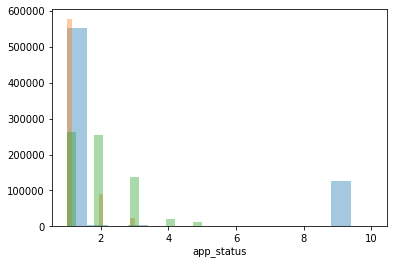

In [ ]:

import seaborn as sns
g = sns.distplot(df['final_outcome'], kde=False, bins=15)
g1 = sns.distplot(df['outcome'], kde=False, bins=15)
g2 = sns.distplot(df['app_status'], kde=False, bins=15)
plt.show()

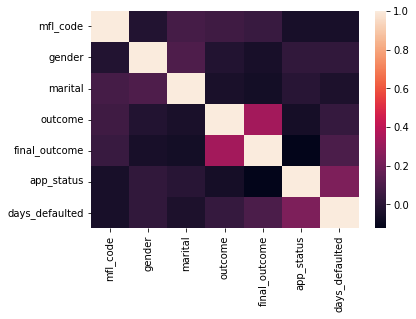

In [ ]:
#predictive modeling
new_df = df.loc[:,['mfl_code','gender', 'appntmnt_date','outcome',
                   'final_outcome',
                   'app_status', 'days_defaulted', 'Appntmnt_yr']]
new_df.fillna(0)
default_df =new_df[new_df.app_status ==1]  
                                 
 #find app_status factor for ploting against date for time series prediction.
#subtracting 0ne(1) to avoild infinity output incase of zero as days defaulted
default_df['status_factor'] = default_df['app_status']*(default_df['days_defaulted'])

default_df.head(2)

corr = df.corr()
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns)

# 
import random as rand

test_percentage = 0.1
validation_percentage = 0.2
train_percentage = 0.7

#calculating the spliting index for numpy array
test_split_ratio = int(test_percentage*len(default_df))
validation_split_ratio = int((validation_percentage+test_percentage)*len(default_df))
#split data into test, valid, and train
test, valid, train = np.split(default_df, [test_split_ratio, validation_split_ratio])

train, test = train_test_split(default_df,test_size=0.4)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)



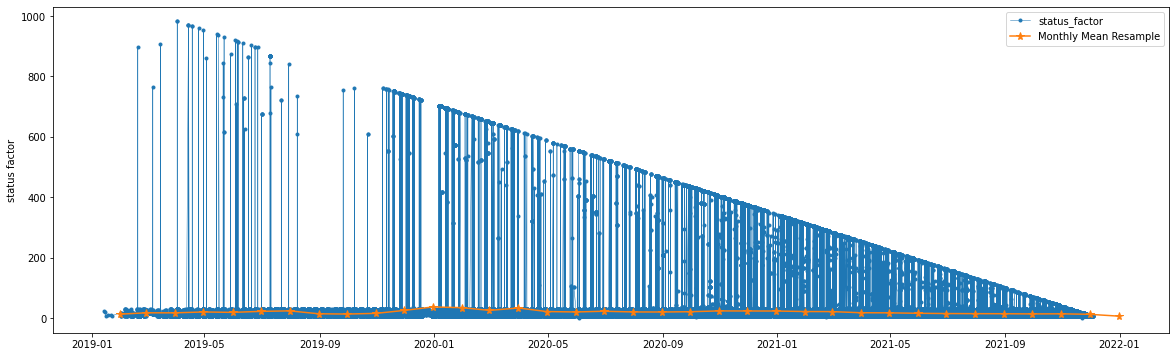

In [ ]:
# Draw Plot
default_df["appointmnt_date"] = default_df["appntmnt_date"].astype('datetime64[ns]')

default_df = default_df.set_index('appointmnt_date')
default_df = default_df.drop(['appntmnt_date'], axis=1)
default_df.sort_values(by='appointmnt_date', ascending = True, inplace=True)
default_df.head()  

y = default_df['status_factor']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='status_factor')
ax.plot(y.resample('M').mean(),marker='*', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('status factor')
ax.legend();



**                                                                      **__**Time series analysis**__. 

Comparing patient app status within the Ushauri app and determining patient patterns over the past years.

Status factor =( app_status ) * (days_defaulted)



In [ ]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive', period = 6000,extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,10)
    plt.show()

Patient appointment Keeping pattern  with general trends since they were registered into the system. 



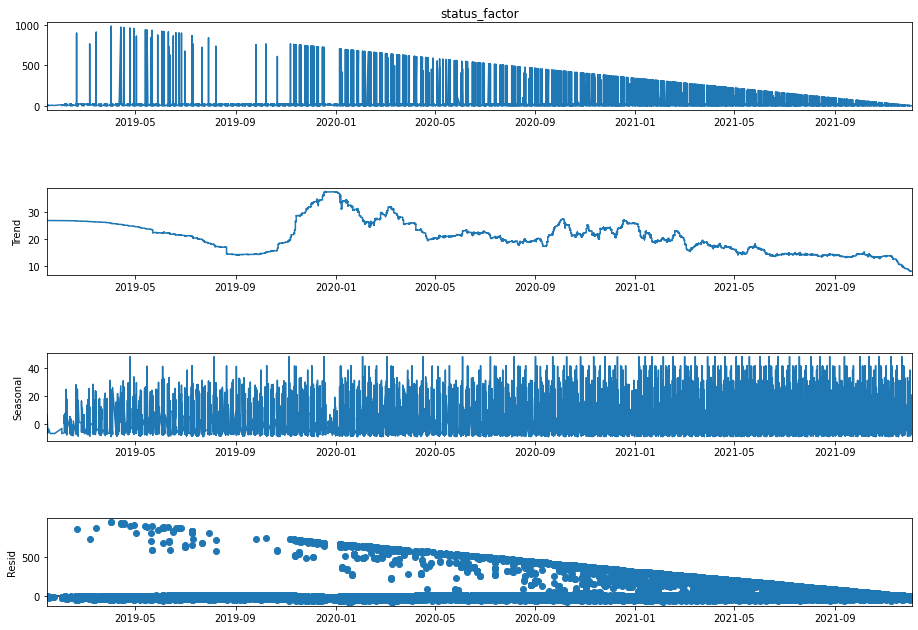

In [ ]:

seasonal_decompose(y)


**modelling and predictions**

In [ ]:
from prophet import Prophet

In [ ]:
prophet_df = default_df.reset_index()
prophet_df = prophet_df[["appointmnt_date","status_factor"]]
prophet_df = prophet_df.rename(columns={'appointmnt_date':'ds','status_factor':'y'})
m = Prophet()
m.fit(prophet_df)

16:44:28 - cmdstanpy - INFO - Chain [1] start processing
16:46:39 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Forcasting into the future
future = m.make_future_dataframe(periods=365) #adjustable dates --(periods = 3, freq = 'M')
forecast = m.predict(future)

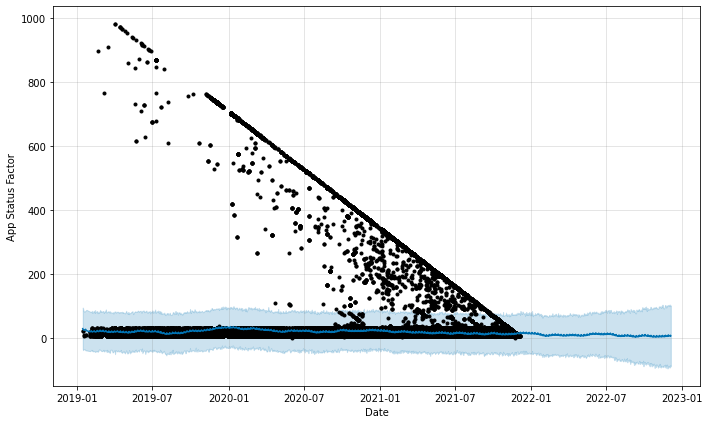

In [ ]:
figure = m.plot(forecast, xlabel='Date', ylabel='App Status Factor')

Using time series to predict future trends and patterns of client, trends per region, and trends per given hospital. The trend results 

targets the most probable app_status  for specific patient or majority  per region. Both weekly patterns, yearly trends can be obtained.



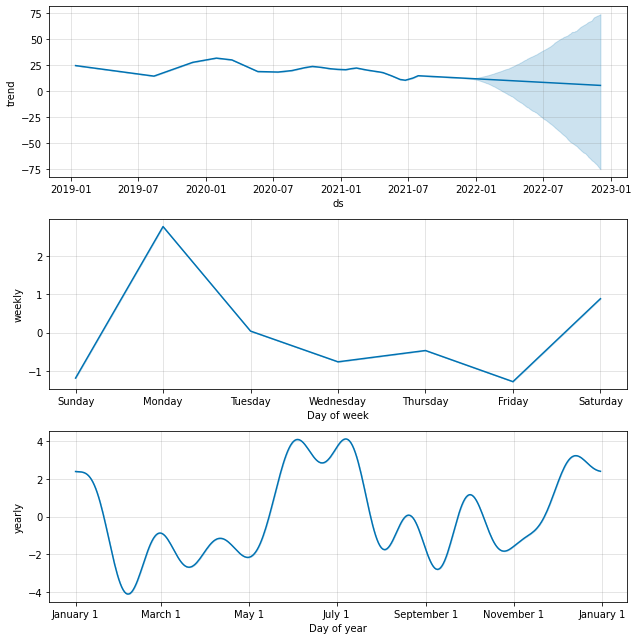

In [ ]:
status_fig = m.plot_components(forecast)

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

#Doing Crossvalidation with 720 (2 years) training data, 120 predictions (4 months) and 240 time intervals (8 months)
cv = cross_validation(m,initial='720 days', period='120 days', horizon = '240 days')
cv.head()

df_p = performance_metrics(cv)
df_p.head()

  0%|          | 0/1 [00:00<?, ?it/s]

16:47:43 - cmdstanpy - INFO - Chain [1] start processing
16:48:41 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mdape,smape,coverage
0,25 days,730.770534,27.032768,10.037366,0.498075,0.530618,0.984706
1,26 days,666.441132,25.815521,9.739899,0.498075,0.533106,0.985865
2,27 days,595.812719,24.409275,9.311326,0.475674,0.531781,0.986916
3,28 days,530.150651,23.025001,9.042881,0.469459,0.534731,0.988022
4,29 days,523.909814,22.889076,8.942893,0.469459,0.535632,0.988071


In [ ]:
cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
111144,2021-12-04,12.982282,-63.907487,101.045663,5.0,2021-04-08
111145,2021-12-04,12.982282,-69.969471,97.283161,5.0,2021-04-08
111146,2021-12-04,12.982282,-70.555499,98.945343,5.0,2021-04-08
111147,2021-12-04,12.982282,-72.404921,99.181989,5.0,2021-04-08
111148,2021-12-04,12.982282,-70.926278,102.816307,5.0,2021-04-08


Curated prediction model  obtained from combination of random forest, gradient boost, KNN and linear regression 

provides results for any new patient within the system. Well tested with more than 95% accuracy.



In [ ]:
# form dependent and independent sets

y = default_df['status_factor']
x = default_df.drop(['status_factor'], axis = 1)

print(y.shape)
print(x.columns)

(263383,)
Index(['mfl_code', 'gender', 'outcome', 'final_outcome', 'app_status',
       'days_defaulted', 'Appntmnt_yr'],
      dtype='object')


In [ ]:
# perform train test split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(210706, 7)
(52677, 7)
(210706,)
(52677,)


In [ ]:
# perform standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Predictive modelling - model creation

In [ ]:
# create the Model

# create a simple Linear Regression Model
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()
model1.fit(x_train, y_train)

y_pred1 = model1.predict(x_test)

# check the Model accuracy
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_test, y_pred1)
rmse = np.sqrt(mse)
print("RMSE Score :", rmse)

r2_score = r2_score(y_test, y_pred1)
print("R2 Score :",r2_score)

RMSE Score : 4.568234650349512e-14
R2 Score : 1.0


In [ ]:
# create a Random Forest Model

from sklearn.ensemble import RandomForestRegressor

model2 = RandomForestRegressor()
model2.fit(x_train, y_train)

y_pred2 = model2.predict(x_test)

# check the Model accuracy
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_test, y_pred2)
rmse = np.sqrt(mse)
print("RMSE Score :", rmse)

r2_score = r2_score(y_test, y_pred2)
print("R2 Score :",r2_score)

RMSE Score : 0.040550298963363825
R2 Score : 0.9999993143101249


In [ ]:
# create a Gradient Boosting Model

from sklearn.ensemble import GradientBoostingRegressor

model3 = GradientBoostingRegressor()
model3.fit(x_train, y_train)

y_pred3 = model3.predict(x_test)

# check the Model accuracy
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_test, y_pred3)
rmse = np.sqrt(mse)
print("RMSE Score :", rmse)

r2_score = r2_score(y_test, y_pred3)
print("R2 Score :",r2_score)

RMSE Score : 0.24007535190160503
R2 Score : 0.9999759655181343


In [ ]:
#create a KNN model
from sklearn.preprocessing import StandardScaler
model4 = KNeighborsClassifier()

X_scaled = sc.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

model4.fit(X_train,y_train)

model4.score(X_test,y_test)

#finding optimal n
best = model4.score(X_test,y_test)
n = 10
for i in range(1,25):
    model4 = KNeighborsClassifier(n_neighbors=i)
    model4.fit(X_train,y_train)
    present = model4.score(X_test,y_test)
    if best < present:
        best,n = present,i
model4_best = KNeighborsClassifier(n_neighbors=n)
model4_best.fit(X_train,y_train)
y4_pred = model4_best.predict(X_test)

model4_best.score(X_test,y_test)


0.9737456574975796

In [ ]:
# create an ensemble by averaging 

avg_model = (y_pred1 + y_pred2 + y_pred3 + y4_pred)/4

# check the Model accuracy
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_test, avg_model)
rmse = np.sqrt(mse)
print("RMSE Score :", rmse)

r2_score = r2_score(y_test, avg_model)
print("R2 Score :",r2_score)

RMSE Score : 0.34858304680540475
R2 Score : 0.9999493298559531


In [ ]:
# create an weighted averaging model

# give 30% weight to gradient boosting
# 30% weight to random forest
# 20% on knn
# and 20% weight to linear regression

weight_avg_model = 0.2*y_pred1 + 0.3*y_pred2 + 0.3*y_pred3 + 0.2*y4_pred

# check the Model accuracy
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_test, weight_avg_model)
rmse = np.sqrt(mse)
print("RMSE Score :", rmse)

r2_score = r2_score(y_test, weight_avg_model)
print("R2 Score :",r2_score)

RMSE Score : 0.28546161107760626
R2 Score : 0.9999660190871934


In [ ]:
##  perform cross validaion

from sklearn.model_selection import cross_val_score
scores = cross_val_score(model3, x, y, cv=5)
print(scores)

[0.92526855 0.99986469 0.99985301 0.99976933 0.99965998]


In [ ]:
"""
# algorithms / models
models = []
models.append(('model1', LinearRegression()))
models.append(('model2', RandomForestRegressor()))
models.append(('model3', GradientBoostingRegressor()))
models.append(('model4', KNeighborsClassifier()))



# evaluate each algorithm / model
num_folds = 10
results = []
names = []


print("Scores for each algorithm:")
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=None)
    start = time.time()
    cv_results = cross_val_score(model, x, y, cv=kfold, scoring='accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))
    """

'\n# algorithms / models\nmodels = []\nmodels.append((\'model1\', LinearRegression()))\nmodels.append((\'model2\', RandomForestRegressor()))\nmodels.append((\'model3\', GradientBoostingRegressor()))\nmodels.append((\'model4\', KNeighborsClassifier()))\n\n\n\n# evaluate each algorithm / model\nnum_folds = 10\nresults = []\nnames = []\n\n\nprint("Scores for each algorithm:")\nfor name, model in models:\n    kfold = KFold(n_splits=num_folds, random_state=None)\n    start = time.time()\n    cv_results = cross_val_score(model, x, y, cv=kfold, scoring=\'accuracy\')\n    end = time.time()\n    results.append(cv_results)\n    names.append(name)\n    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))\n    '